# Detekcja krawędzi

## Cel ćwiczenia

- Zapoznanie z metodami detekcji krawędzi:
    - Sobel, Prewitt, Roberts - przypomnienie,
    - Laplasjan z Gaussa (LoG – ang. Laplacian of Gaussian),
    - Canny.

Detekcja krawędzi przez wiele lat była podstawą algorytmów segmentacji.
Krawędzie wykrywane są najczęściej z wykorzystaniem pierwszej (gradient) i drugiej (Laplasjan) pochodnej przestrzennej.
Wykorzystanie obu metod zaprezentowane zostało w ćwiczeniu *Przetwarzanie wstępne. Filtracja kontekstowa*.

W niniejszym ćwiczeniu poznane detektory krawędzi zostaną porównane z bardziej zaawansowanymi: Laplasjan z funkcji Gaussa (LoG), Zero Crossing i Canny.

## Laplasjan z Gaussa (LoG)

Funkcja Gaussa:<br>
\begin{equation}
h(r) = e^{\frac{-r^2}{2 \sigma^2}}
\end{equation}<br>
gdzie:
- $r^2 = x^2 + y^2$
- $\sigma$ to odchylenie standardowe.

Działanie filtracji Gaussowskiej zostało przedstawione w ćwiczeniu "Przetwarzanie wstępne". W jej wyniku następuje rozmazanie obrazu.
Laplasjan tej funkcji dany jest wzorem:

\begin{equation}
\nabla^2 h(r) = \frac{r^2 - 2\sigma^2}{\sigma^4} e^{-\frac{r^2}{2\sigma^2}}
\end{equation}

Funkcję (z oczywistych powodów) nazywamy Laplasjan z Gaussa (LoG).
Ponieważ druga pochodna jest operacją liniową, konwolucja obrazu z $\nabla^2 h(r)$ daje taki sam efekt jak zastosowanie filtracji Gaussa na obrazie, a następnie obliczenie Laplasjanu z wyniku.
Lokalizacja krawędzi polega na znalezieniu miejsca, gdzie po filtracji LoG następuje zmiana znaku.

1. Wczytaj obraz *house.png*.
2. Wykonaj rozmycie Gaussowskie obrazu wejściowego.
W tym celu wykorzysaj funkcję `cv2.GaussianBlur(img, kSize, sigma)`.
Pierwszy argument jest obrazem wejśćiowym.
Drugi jest rozmiarem filtru (podanym w nawiasach okrągłych, np. *(3, 3)*).
Trzecim argumentem jest odchylenie standardowe. Wartość jest dobrana automatycznie, jeśli zosanie podana wartość `0` (będą równe rozmiarowi).
3. Oblicz laplasjan obrazu rozmytego.
W tym celu wykorzysaj funkcję `cv2.Laplacian(img, ddepth)`.
Pierszym argumentem jest obraz wejściowy.
Drugim argumentem jest typ danych wejściowych. Użyj `cv2.CV_32F`.
4. Wyznacz miejsca zmiany znaku.
Zaimplementuj funkcję `crossing(LoG, thr)`:
    - Najpierw stwórz tablicę, do której zostanie zapisany wynik.
    Jej rozmiar jest taki sam jak przetwarzanego obrazu.
    - Następnie wykonaj pętle po obrazie (bez ramki jednopikselowej).
    W każdej iteracji stwórz otoczenie o rozmiarze $3 \times 3$.
    Dla otoczenia oblicz wartość maksymalną i minimalną.
    - Jeśli wartości te mają przeciwne znaki, to do danego miejsca tablicy przypisz wartość:
        - jeśli piksel wejściowy > 0, to dodaj do niego wartość bezwzględną minimum.
        - jeśli piksel wejściowy < 0, to do jego wartości bezwzględnej dodaj maksimum.
    - Zmień zakres wykonanej tablicy do $<0, 255>$.
    - Wykonaj progowanie tablicy. Próg jest argumentem wejściowym.
    - Przeskaluj dane binarne do wartości `[0, 255]`.
    - Wykonaj konwersję do typu *uint8*.
    - Wykonaj rozmycie medianowe wyniku.
    Wykorzystaj funkcję `cv2.medianBlur(img, kSize)`.
    Pierwszym argumentem jest obraz wejśćiowy, a drugim rozmiar filtra.
    - Zwróć wyznaczoną tablicę.
5. Wyświetl obraz wynikowy.
6. Dobierz parametry (rozmiar filtru Gaussa, odchylenie standardowe, próg binaryzacji) tak, by widoczne były kontury domu, ale nie dachówki.

(-0.5, 556.5, 416.5, -0.5)

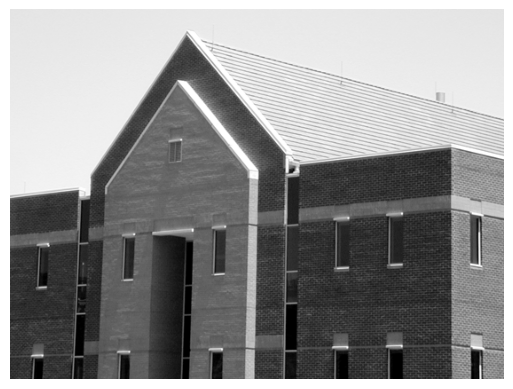

In [ ]:
import cv2
from matplotlib import pyplot as plt
import numpy as np
import math
import os
import requests

url = 'https://raw.githubusercontent.com/vision-agh/poc_sw/master/09_Canny/'

fileNames = ["dom.png"]
for fileName in fileNames:
  if not os.path.exists(fileName):
      r = requests.get(url + fileName, allow_redirects=True)
      open(fileName, 'wb').write(r.content)

I_dom = cv2.imread("dom.png", cv2.IMREAD_GRAYSCALE)
plt.imshow(I_dom, "gray")
plt.axis("off")

(-0.5, 556.5, 416.5, -0.5)

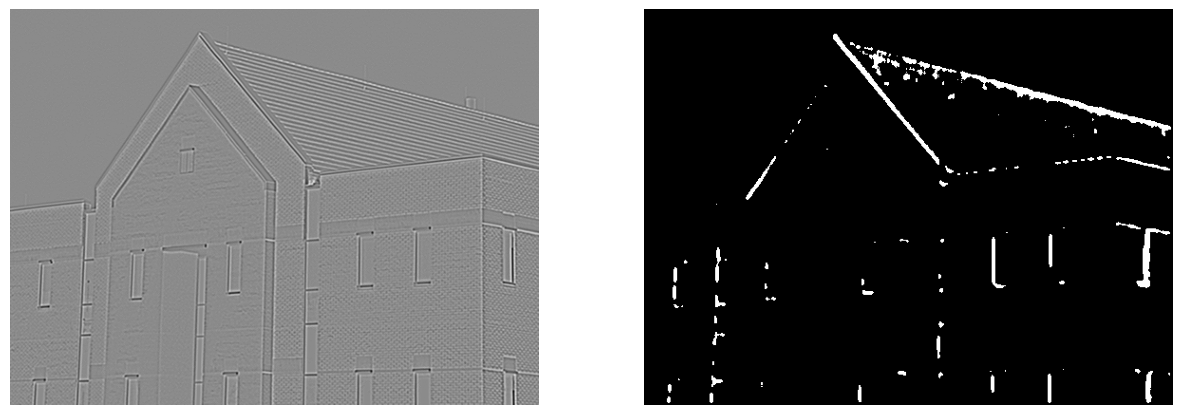

In [ ]:
def crossing(image, threshold):
    zero_array = np.zeros((image.shape[0], image.shape[1]))

    for i in range(1, image.shape[0] - 1):
        for j in range(1, image.shape[1] - 1):

            # Obliczanie wartości otoczenia 3x3
            neighbourhood = image[i - 1 : i + 2, j - 1 : j + 2]
            min = neighbourhood.min()
            max = neighbourhood.max()

            if min * max < 0:
                if image[i, j] > 0:
                    zero_array[i, j] = image[i, j] + np.abs(min)
                elif image[i, j] < 0:
                    zero_array[i, j] = np.abs(image[i, j]) + max

    nomalized = cv2.normalize(zero_array, None, 0, 255, cv2.NORM_MINMAX)

    # Progowanie
    binary = np.where(nomalized < threshold, 0, 1)
    # Skalowanie i konwersja
    binary = (binary * 255).astype("uint8")
    # Rozmycie medianowe
    blured = cv2.medianBlur(binary, 5)

    return blured

gaussian_blur = cv2.GaussianBlur(I_dom, (3, 3), 0)
LoG = cv2.Laplacian(gaussian_blur, cv2.CV_32F)
I_dom_crossing = crossing(LoG, 90)

fig, axs = plt.subplots(1, 2, figsize=(15, 15))
axs[0].imshow(LoG, "gray")
axs[0].axis("off")
axs[1].imshow(I_dom_crossing, "gray")
axs[1].axis("off")

## Algorytm Canny'ego

> Algorytm Canny'ego to często wykorzystywana metoda detekcji krawędzi.
> Zaproponowana została w 1986r. przez Johna F. Cannego.
> Przy jego projektowaniu założono trzy cele:
> - niska liczba błędów - algorytm powinien znajdywać wszystkie krawędzie oraz generować jak najmniej fałszywych detekcji,
> - punkty krawędziowe powinny być poprawnie lokalizowane - wykryte punkty powinny być jak najbardziej zbliżone do rzeczywistych,
> - krawędzie o szerokości 1 piksela - algorytm powinien zwrócić jeden punkt dla każdej rzeczywistej krawędzi.

Zaimplementuj algorytm detekcji krawędziCanny'ego:
1. W pierwszym kroku obraz przefiltruj dwuwymiarowym filtrem Gaussa.
2. Następnie oblicz gradient pionowy i poziomy ($g_x $ i $g_y$).
Jedną z metod jest filtracja Sobela.
3. Dalej oblicz amplitudę:
$M(x,y)  = \sqrt{g_x^2+g_y^2}$ oraz kąt:
$\alpha(x,y) = arctan(\frac{g_y}{g_x})$.
Do obliczenia kąta wykorzystaj funkcję `np.arctan2(x1, x2)`.
Wynik jest w radianach.
4. W kolejnym etapie wykonaj kwantyzację kątów gradientu.
Kąty od $-180^\circ$ do $180^\circ$ można podzielić na 8 przedziałów:
[$-22.5^\circ, 22.5^\circ$], [$22.5^\circ, 67.5^\circ$],
[$67.5^\circ, 112.5^\circ$], [$112.5^\circ, 157.5^\circ$],
[$157.5^\circ, -157.5^\circ$], [$-157.5^\circ, -112.5^\circ$],
[$-112.5^\circ, -67.5^\circ$], [$-67.5^\circ, -22.5^\circ$].
Przy czym należy rozpatrywać tylko 4 kierunki:
    - pionowy ($d_1$),
    - poziomy ($d_2$),
    - skośny lewy ($d_3$),
    - skośny prawy ($d_4$).
5. Dalej przeprowadź eliminację pikseli, które nie mają wartości maksymalnej (ang. *nonmaximal suppresion*).
Celem tej operacji jest redukcja szerokości krawędzi do rozmiaru 1 piksela.
Algorytm przebiega następująco.
W rozpatrywanym otoczeniu o rozmiarze $3 \times 3$:
    - określ do którego przedziału należy kierunek gradientu piksela centralnego ($d_1, d_2, d_3, d_4$).
    - przeanalizuje sąsiadów leżących na tym kierunku.
Jeśli choć jeden z nich ma amplitudę większą niż piksel centralny, to należy uznać, że nie jest lokalnym maksimum i do wyniku przypisać $g_N(x,y) = 0$.
W przeciwnym przypadku $g_N(x,y) = M(x,y)$.
Przez $g_N$ rozumiemy obraz detekcji lokalnych maksimów.
Zaimplementuj funkcję `nonmax`.
Pierwszym argementem jest macierz kierunków (po kwantyzacji).
Drugim argumentem jest macierz amplitudy.
6. Ostatnią operacją jest binaryzacja obrazu $g_N$.
Stosuje się tutaj tzw. binaryzację z histerezą.
Wykorzystuje się w niej dwa progi: $T_L$ i $T_H$, przy czym $T_L < T_H$.
Canny zaproponował, aby stosunek progu wyższego do niższego był jak 3 lub 2 do 1.
Rezultaty binaryzacji można opisać jako:<br>
$g_{NH}(x,y) = g_N(x,y) \geq TH $<br>
$g_{NL}(x,y) = TH > g_N(x,y) \geq TL $<br>
Można powiedzieć, że na obrazie $g_{NH}$ są "pewne" krawędzie.
Natomiast na $g_{NL}$ "potencjalne".
Często krawędzie "pewne" nie są ciągłe.
Dlatego wykorzystuje się obraz $g_{NL}$ w następującej procedurze:
    - Stwórz stos zawierający wszystkie piksele zaznaczone na obrazie $g_{NH}$.
W tym celu wykorzystaj listę współrzędnych `[row, col]`.
Do pobrania elementu z początku służy metoda `list.pop()`.
Do dodania elementu na koniec listy służy metoda `list.append(new)`.
    - Stwórz obraz, który będzie zawierał informację czy dany piksel został już odwiedzony.
    - Stwórz obraz, któy zawierać będzie wynikowe krawędzie.
Jej rozmiar jest równy rozmiarowi obrazu.
    - Wykonaj pętlę, która będzie pobierać elementy z listy, dopóki ta nie będzie pusta.
W tym celu najlepiej sprawdzi się pętla `while`.
    - W każdej iteracji pobierz element ze stosu.
    - Sprawdź czy dany element został już odwiedzony.
    - Jeśli nie został, to:
        - Oznacz go jako odwiedzony,
        - Oznacz piksel jako krawędź w wyniku,
        - Sprawdź otoczenie piksela w obrazie $g_{NL}$,
        - Dodaj do stosu współrzędne otoczenia, które zawierają krawędź (potencjalną).
        Można to wykoanać np. pętlą po stworzonym otoczeniu.
7. Wyświetl obraz oryginalny, obraz $g_{NH}$ oraz obraz wynikowy.

Pomocnicze obrazy $g_{NH}$ i $g_{NL}$ zostały wprowadzone dla uproszczenia opisu.
Algorytm można zaimplementować wbardziej "zwarty" sposób.

Na podstawie powyższego opisu zaimplementuj algorytm Cannego.

In [ ]:
def canny(image, threshold_high, treshold_low):
    # Podwójne przefiltrowanie filtrem Gaussa
    img_gaussian_blur = cv2.GaussianBlur(image, (5, 5), 1)

    # Gradient pionowy i poziomy, filtracja Sobela
    s1 = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
    s2 = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])
    g_x = scipy.signal.convolve2d(img_gaussian_blur, s1, mode="same")
    g_y = -scipy.signal.convolve2d(img_gaussian_blur, s2, mode="same")

    # Obliczenie amplitudy i kąta alfa
    magnitude = np.sqrt(g_x**2 + g_y**2)
    alpha_deg = np.rad2deg(np.arctan2(g_y, g_x))
    alpha_deg[alpha_deg < 0] += 180

    # Kwantyzacja kątów gradientu
    quantized_matrix = np.zeros_like(image)
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            if (0 <= alpha_deg[i, j] < 22.5) or (157.5 <= alpha_deg[i, j] <= 180):
                quantized_matrix[i, j] = 0
            elif 22.5 <= alpha_deg[i, j] < 67.5:
                quantized_matrix[i, j] = 1
            elif 67.5 <= alpha_deg[i, j] < 112.5:
                quantized_matrix[i, j] = 2
            elif 112.5 <= alpha_deg[i, j] < 157.5:
                quantized_matrix[i, j] = 3

    # Eliminacja pikseli bez wartości maksymalnej - nomax
    g_n = nonmax(quantized_matrix, magnitude)

    # Binaryzacja obrazu g_n
    g_nh = g_n >= threshold_high
    g_nl = (g_n >= treshold_low) & (g_n < threshold_high)

    # Budowanie Stosu
    stack_g_nh = []
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            if g_nh[i, j] == 1:
                stack_g_nh.append([i, j])

    # Obraz odwiedzonych elementów
    visited = np.zeros_like(image)
    # Obraz krawędzi wynikowych
    result = np.zeros_like(image)

    while stack_g_nh:
        element = stack_g_nh.pop()
        if visited[element[0], element[1]] == 0:
            visited[element[0], element[1]] = 1
            result[element[0], element[1]] = 1
            # Otoczenie 3x3
            for i in range(-1, 2):
                for j in range(-1, 2):
                    if g_nl[element[0] + i, element[1] + j] == 1:
                        stack_g_nh.append([element[0] + i, element[1] + j])

    return result, g_nh.astype(np.uint8)

def nonmax(quantized_matrix, M_amplitude):
    g_n = np.zeros((quantized_matrix.shape[0], quantized_matrix.shape[1]))

    for i in range(1, quantized_matrix.shape[0] - 1):
        for j in range(1, quantized_matrix.shape[1] - 1):
                if quantized_matrix[i, j] == 0:
                    if (M_amplitude[i, j] > M_amplitude[i, j - 1] and M_amplitude[i, j] > M_amplitude[i, j + 1]):
                        g_n[i, j] = M_amplitude[i, j]
                    else:
                        g_n[i, j] = 0
                elif quantized_matrix[i, j] == 1:
                    if (M_amplitude[i, j] > M_amplitude[i - 1, j + 1] and M_amplitude[i, j] > M_amplitude[i + 1, j - 1]):
                        g_n[i, j] = M_amplitude[i, j]
                    else:
                        g_n[i, j] = 0
                elif quantized_matrix[i, j] == 2:
                    if (M_amplitude[i, j] > M_amplitude[i - 1, j] and M_amplitude[i, j] > M_amplitude[i + 1, j]):
                        g_n[i, j] = M_amplitude[i, j]
                    else:
                        g_n[i, j] = 0
                elif quantized_matrix[i, j] == 3:
                    if (M_amplitude[i, j] > M_amplitude[i - 1, j - 1] and M_amplitude[i, j] > M_amplitude[i + 1, j + 1]):
                        g_n[i, j] = M_amplitude[i, j]
                    else:
                        g_n[i, j] = 0
    return g_n

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


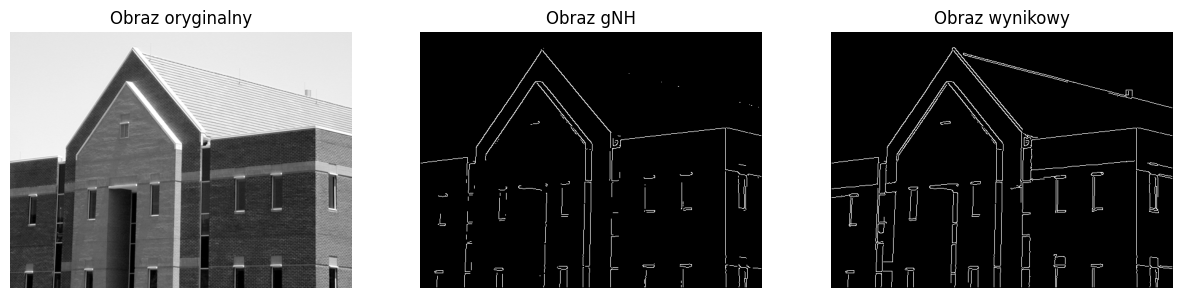

In [ ]:
import scipy

canny_result, g_nh = canny(I_dom, 180, 40)

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.title("Obraz oryginalny")
plt.imshow(I_dom, cmap="gray")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.title("Obraz gNH")
plt.imshow(g_nh * 255, cmap="gray")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.title("Obraz wynikowy")
plt.imshow(canny_result * 255, cmap="gray")
plt.axis("off")

plt.show()

## Algorytm Canny'ego - OpenCV

1. Wykonaj dektekcję krawędzi metodą Canny'ego wykorzystując funkcję `cv2.Canny`.
    - Pierwszym argumentem funkcji jest obraz wejściowy.
    - Drugim argumentem jest mniejszy próg.
    - Trzecim argumentem jest większy próg.
    - Czwarty argument to tablica, do której wpisany zostanie wynik.
    Można zwrócić go przez wartość i podać wartość `None`.
    - Piąty argument to rozmiar operatora Sobela (w naszym przypadku 3).
    - Szósty argument to rodzaj używanej normy.
    0 oznacza normę $L_1$, 1 oznacza normę $L_2$. Użyj $L_2$.
2. Wynik wyświetl i porównaj z własną implementacją.

Text(0.5, 1.0, 'cv2')

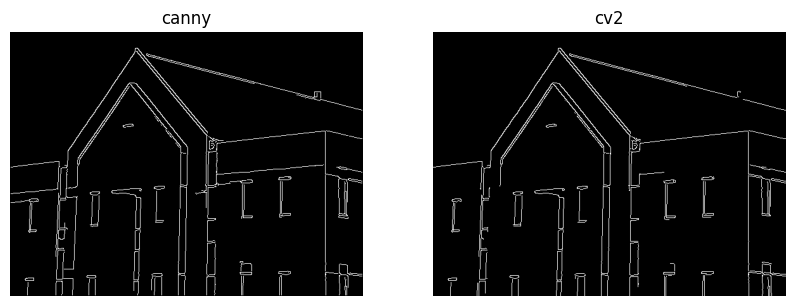

In [ ]:
canny_cv2_gaussian_blur = cv2.GaussianBlur(I_dom, (3, 3), 1)
canny_cv2 = cv2.Canny(canny_cv2_gaussian_blur, 100, 200, None, 3, 1)

fig, axs = plt.subplots(1, 2, figsize=(10, 10))
axs[0].imshow(canny_result, "gray")
axs[0].axis("off")
axs[0].set_title("canny")
axs[1].imshow(canny_cv2, "gray")
axs[1].axis("off")
axs[1].set_title("cv2")